Using a 2D nvmpy grid, we'll approximate the continous space of navier stokes. Assuming a uniform cartesian grid, with uniform grid spacing "h".<br><br>

For each position in the field, we need to store the following <br>
- Velocity components in x and y directions : u[i,j], v[i,j]
- Pressure at each point : p[i,j]

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse 

from IPython import display

In [54]:
#Domeneparameter:
Lx      = 1.0       #Length in x-direction
Ly      = 1.0
Nx, Ny  = 100, 100    #Number of grid points
h       = Lx / (Nx - 1)
u_inlet = 0.5
n_f     = 0.2       #Noise factor, determines end points of distribution for noise


#Lagrer X og Y koordinatarray:
x       = np.linspace(0, Lx, Nx)
y       = np.linspace(0, Ly, Ny)


#Fluidparameter:
nu      = 1e-6 #Kinematisk viskositet
rho     = 1000
g       = 0.0


#Tidsparameter:
dt      = 0.00001
t_end   = 20.0
n_steps = int(t_end / dt)


#Initialiserer hastighetsfelt og trykk:
u       = np.zeros((Ny, Nx))        #NB! Hugs at i er langs y retninga
v       = np.zeros((Ny, Nx))
P       = np.ones((Ny, Nx))         #Changed to Np.ones for better stability

#Simuleringsparameter:
contour = False

def add_starting_noise():
    global u,v
    u += np.random.uniform(-n_f,n_f, size=(Ny,Nx))  #Add noise to u
    v += np.random.uniform(-n_f,n_f, size=(Ny,Nx))  

**Time stepping and Velocity field update**

In [ ]:
#Implementere time stepping for diskrete verdier:

def calculate_intermediate_viscous_term_u(u, nu, h, i, j):
    """Viscous term value for u-component at (i,j) = (x,y)."""
    return nu * ( (u[j, i+1] + u[j, i-1] - 2*u[j, i]) / h**2  +  (u[j+1, i] + u[j-1, i] - 2*u[j, i]) / h**2 )

def calculate_intermediate_viscous_term_v(v, nu, h, i, j):
    """Viscous term value for v-component at (i, j)."""
    return nu * ( (v[j+1, i] + v[j-1, i] - 2*v[j, i]) / h**2  +  (v[j, i+1] + v[j, i-1] - 2*v[j, i]) / h**2 )

#Used in part of the momentum equation, i.e solving for time
def calculate_intermediate_convective_term_u(u, v, h, i, j):
    return (u[j,i])*(u[j,i+1] - u[j,i-1])/(2*h) + (v[j,i])*(u[j+1,i] - u[j-1,i])/(2*h)

def calculate_intermediate_convective_term_v(u, v, h, i, j):
    return u[j,i]*(v[j,i+1] - v[j,i-1])/(2*h) + v[j,i]*(v[j+1,i] - v[j-1,i])/(2*h)

#Calculating final velocity field
def calculate_pressure_term_u(P, i,j):
    """Calculates linearization of the partial derivative for x in a point"""
    return (P[j,i+1]-P[j,i-1])/(2*h)

def calculate_pressure_term_v(P,i,j):
    """Calculates linearization of the partial derivative for y in a point"""
    return (P[j+1,i]-P[j-1,i])/(2*h)

def calculate_PPE_source(u,v,rho,h):
    
    source = np.zeros(shape=(Ny-2,Nx-2))
    
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            source[j-1,i-1] = rho * ( ((u[j, i+1] - u[j, i-1]) / (2*h))**2 + \
        ((u[j+1, i] - u[j-1, i]) / (2*h))**2 + \
        ((v[j, i+1] - v[j, i-1]) / (2*h))**2 + \
        ((v[j+1, i] - v[j-1, i]) / (2*h))**2 )
    
    return source

def solve_PPE(u,v,rho,h,P):
    """Solves PPE using scipy.sparse"""
    
    # Calculate the source term
    source = calculate_PPE_source(u, v, rho, h)

    # Number of interior points
    N_int_x = Nx - 2
    N_int_y = Ny - 2
    n = N_int_x * N_int_y  # Total number of interior points

    # Create the diagonals for the Laplacian matrix
    main_diag = -4 * np.ones(n) / h**2
    off_diag = 1 * np.ones(n) / h**2

    # Create the sparse matrix using diags
    diagonals = [main_diag, off_diag, off_diag, off_diag, off_diag]
    offsets = [0, 1, -1, N_int_x, -N_int_x]
    A = scipy.sparse.diags(diagonals, offsets, shape=(n, n), format="csr")

    # Flatten the source term into b
    b = source.flatten()

    # Solve the linear system A @ p = b for p
    p = scipy.sparse.linalg.spsolve(A, b)

    # Reshape p back into the interior of P
    P[1:Ny-1, 1:Nx-1] = p.reshape((N_int_y, N_int_x))
    
    #No gradient pressure values for the edges 
    P[:, 0]         = -0.5 * rho * u_inlet**2   # Dirichlet condition
    P[:,Nx-1]       = P[:,Nx-2]                 # Neumann condition
    ##Avoid assigning the edge conditions twice (Neumann conditon)
    P[0,1:Nx-1]     = P[1,   1:Nx-1]             #Bottom edge         
    P[Ny-1,1:Nx-1]  = P[Ny-2,1:Nx-1]             #Top edge
    
    return P

def enforce_boundary_conditions(u_int, v_int):
    """Returns the input arrays wiht boundary conditions enforced"""
    ##Left boundary: Flow tunnel inlet
    u_int[:,0]          = u_inlet
    v_int[:,0]          = 0.0
    
    ##Right boundary: Outflow (zero gradient)
    u_int[:,Nx-1]       = u[:,Nx-2]
    v_int[:,Nx-1]       = v[:,Nx-2]
    
    ##Top and bottom boundary : Infinite square condition :: No gradient
    u_int[0,1:Nx-1]     = u_int[1,1:Nx-1]   #Added slice for x direction to avoid setting it twice
    v_int[0,1:Nx-1]     = v_int[1,1:Nx-1]
    
    u_int[Ny-1,1:Nx-1]  = u_int[Ny-2,1:Nx-1]  
    v_int[Ny-1,1:Nx-1]  = v_int[Ny-2,1:Nx-1]
    
    return u_int, v_int
    
def update_velocities():
    """Mutates global velocity and pressure fields"""
    global u,v,P
    u_int = np.zeros((Ny,Nx))
    v_int = np.zeros((Ny,Nx))
    
    
    #Iterating through all values:
    k = dt/rho          #Constant
    for i in range(1,Nx-1):
        for j in range(1, Ny-1):
            u_int[j,i] = (calculate_intermediate_viscous_term_u(u,nu,h,i,j) - calculate_intermediate_convective_term_u(u,v,h,i,j))*k + u[j,i]
            v_int[j,i] = (calculate_intermediate_viscous_term_v(v,nu,h,i,j) - calculate_intermediate_convective_term_v(u,v,h,i,j) - g)*k + v[j,i]  #Gravity works in y direction, if applicable
            
    #Enforce boundary conditions:
    u_temp, v_temp = enforce_boundary_conditions(u_int, v_int)
    
    #Calculate new Pressure from intermediate velocities:
    P = solve_PPE(u_temp, v_temp, rho, h, P)
    
    #Calculate final velcoity field utilizing the pressure:
    for i in range(1,Nx-1):
        for j in range(1, Ny-1):
            u[j,i] = u_int[j,i] - k*calculate_pressure_term_u(P,i,j)
            v[j,i] = v_int[j,i] - k*calculate_pressure_term_v(P,i,j)
            
    #Enforce boundary conditions on final velocity field:
    u, v = enforce_boundary_conditions(u,v)

**Plotting and Main time loop**

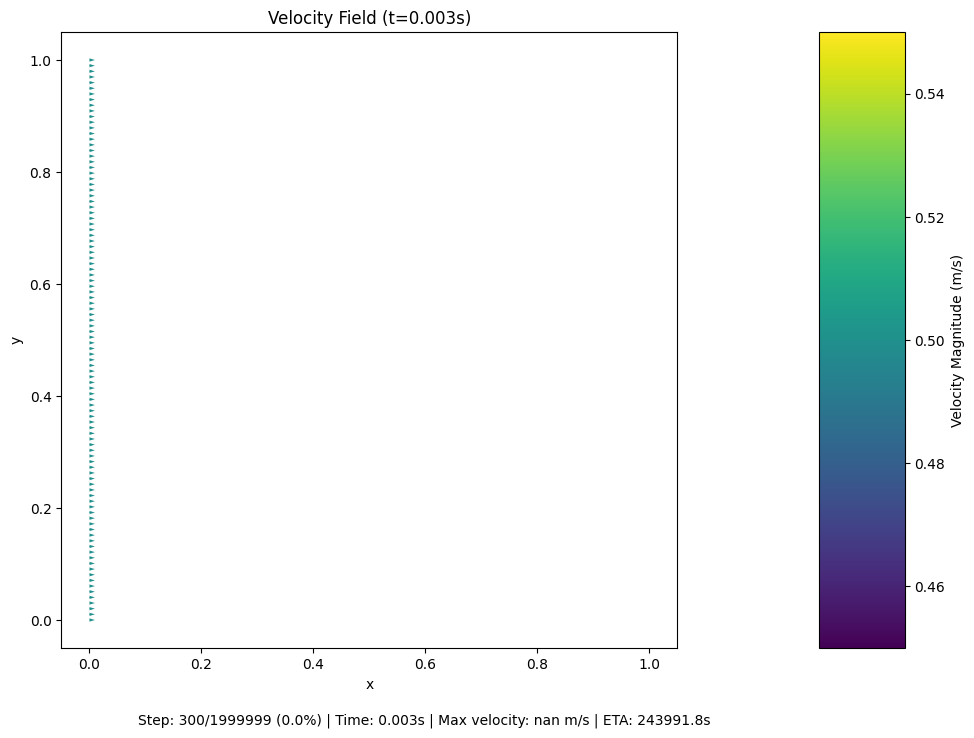

Simulation stopped by user


<Figure size 640x480 with 0 Axes>

Simulation completed in 37.92 seconds
Average time per step: 0.02 ms


In [ ]:

def plot_velocity_field(fig, ax, cbar_ax, time_elapsed):
    """Plot velocity field with timestamp and proper refreshing"""
    # Clear existing content
    ax.clear()
    cbar_ax.clear()
    
    # Calculate velocity data only once
    velocity_magnitude = np.sqrt(u**2 + v**2)
    max_vel = np.max(velocity_magnitude)
    
    # Use pre-computed meshgrid if available or create new one
    if not hasattr(plot_velocity_field, 'mesh_created'):
        plot_velocity_field.X_grid, plot_velocity_field.Y_grid = np.meshgrid(x, y)
        plot_velocity_field.mesh_created = True
    
    # Create new quiver plot with optimized parameters
    q = ax.quiver(
        plot_velocity_field.X_grid, 
        plot_velocity_field.Y_grid, 
        u, v, 
        velocity_magnitude,
        cmap="viridis",
        scale=max(50, max_vel * 2),  # Dynamic scaling based on velocity
        scale_units='xy'
    )
    
    # Set plot properties
    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Velocity Field (t={time_elapsed:.3f}s)")
    
    # Recreate colorbar with better formatting
    cbar = fig.colorbar(q, cax=cbar_ax)
    cbar.set_label("Velocity Magnitude (m/s)")
    
    # Add contour if enabled - use fewer levels for efficiency
    if 'contour' in globals() and contour:
        levels = np.linspace(0, max_vel, 10)
        contour_plot = ax.contourf(
            plot_velocity_field.X_grid, 
            plot_velocity_field.Y_grid, 
            velocity_magnitude, 
            levels=levels, 
            alpha=0.3
        )
    
    return max_vel

def main():
    
    #Starting noise and pressure
    add_starting_noise()
    
    # Enable interactive mode
    plt.ion()
    
    # Create figure and axes once with optimized layout
    plt.close('all')
    fig = plt.figure(figsize=(12, 8))
    
    # Use GridSpec for more flexible layout
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(1, 20, figure=fig)
    ax = fig.add_subplot(gs[0, :17])  # Main plot takes 85% of width
    cbar_ax = fig.add_subplot(gs[0, 18:])  # Colorbar takes 10% of width
    
    # Initialize timing variables
    time_elapsed = 0
    last_plot_time = 0
    plot_interval = 10  # Plot every 10 steps
    start_time = time.time()
    
    # Status display setup
    status_text = fig.text(0.5, 0.01, "", ha='center', va='bottom')
    
    try:
        for n in range(n_steps):
            update_velocities()
            time_elapsed += dt
            
            # Plot at regular intervals
            if n % plot_interval == 0:
                # Measure performance
                iter_start = time.time()
                
                # Update the plot
                max_vel = plot_velocity_field(fig, ax, cbar_ax, time_elapsed)
                
                # Update status display
                elapsed = time.time() - start_time
                eta = (elapsed / (n+1)) * (n_steps - n - 1) if n > 0 else 0
                status = (f"Step: {n}/{n_steps} ({n/n_steps*100:.1f}%) | "
                          f"Time: {time_elapsed:.3f}s | "
                          f"Max velocity: {max_vel:.4f} m/s | "
                          f"ETA: {eta:.1f}s")
                status_text.set_text(status)
                print(status)
                
                # Critical for updating display in Jupyter
                fig.canvas.draw_idle()
                display.clear_output(wait=True)
                display.display(fig)
                plt.pause(0.001)
                
                # Adaptive plot interval - reduce frequency if slow
                iter_time = time.time() - iter_start
                if iter_time > 0.5:  # If plotting takes more than 0.5s
                    plot_interval = min(50, plot_interval + 5)  # Increase interval
                elif iter_time < 0.1 and plot_interval > 10:  # If plotting is fast
                    plot_interval = max(10, plot_interval - 5)  # Decrease interval
    
    except KeyboardInterrupt:
        print("Simulation stopped by user")
    
    finally:
        plt.ioff()
        # Final display
        max_vel = plot_velocity_field(fig, ax, cbar_ax, time_elapsed)
        status_text.set_text(f"Simulation complete - Final time: {time_elapsed:.3f}s, Max velocity: {max_vel:.4f} m/s")
        plt.tight_layout()
        plt.show()
        
        # Report performance metrics
        total_time = time.time() - start_time
        print(f"Simulation completed in {total_time:.2f} seconds")
        print(f"Average time per step: {total_time/n_steps*1000:.2f} ms")
    
    return

main()

Now we need to discretize the derivatives. This can be done using finite difference approximations - for this we will use the central difference approximation: <br> <br>

For example, for pressure this becomes: dell p / dell x = (P[i+1,j]- P[i-1,j])/2h.
<br><br>

Continuing, we need discretizations of the second order derivatives, laplacian operator and the convective term (see notes):  <br><br>

For Time, we use the forward difference (we will be stepping forwards in time)


    """    
    #Defining steps
    i_forward   = i + 1
    i_backward  = i - 1
    j_forward   = j + 1
    j_backward  = j - 1
    
    #Doing edge cases
    X_edge = j % (Nx-1) == 0
    Y_edge = i % (Ny-1) == 0

    if X_edge:
        if j == Ny-1:   j_forward   = 0
        else:           j_backward  = Ny-1
    if Y_edge: 
        if i == Nx-1:   i_forward   = 0
        else:           i_backward  = Nx-1"""